## importación de librerias

In [71]:

import pandas as pd
import numpy as np

#Visualizaciones
import matplotlib.pyplot as plt     
import seaborn as sns 

In [30]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## Carga de datos

In [31]:
df = pd.read_csv("../data/raw/autorenew.csv", parse_dates=["dateCrawled", "dateCreated","lastSeen"])
df.head()

,dateCrawled,name,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,private,offer,480,NaN,1993,manually,0.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,private,offer,18300,coupe,2011,manually,187.0,NaN,125000,5,diesel,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",private,offer,9800,suv,2004,automatic,161.0,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,private,offer,1500,small car,2001,manually,74.0,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600,small car,2008,manually,68.0,fabia,90000,7,diesel,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


## Selección de columnas

Vamos a eliminar columnas que no nos aportan información relevante:
- `dateCrawled`,`dateCreated` y `lastSeen`: En el EDA preliminar vimos que los anuncios son enttre 2017 y 2016, mas allá de eso, no aporta más información.
- `seller`: Todos los valores son private salvo 3 entradas, que son comercial. Eliminamos directamente la columna.
- `offerType`: Todos los valores son offer menos 12 entradas, que son request. Podemos eliminar la columna y los vehiculos que son request.
- `model`: Hay más de 250 entradas y es una subcategoría de `brand`.Se podria dejar para un análisis más granular, pero ahora vamos a eliminarla.
- `monthOfRegistration`: Podríamos hacer un análisis de estacionalidad o por temporada, pero no será el caso.Ademas hay un valor que es 0, que es imposible para meses y sería realmente desconocido.Utilizaremos sólamente `yearOfRegistration`.
- `nrOfPictures`: Todos los valores son 0, no aporta valor.
- `postalCode`: Corresponde a códigos postales y podría tratarse como categórica. No nos aporta mucha información que nos resulte útil, por ello decidimos eliminarla.

### Eliminar duplicados


In [32]:
df = df.drop_duplicates()

In [33]:
df.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'vehicleType',
       'yearOfRegistration', 'gearbox', 'powerCV', 'model', 'kilometer',
       'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage',
       'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen'],
      dtype='object')

In [34]:
columnas_eliminar = [
    "dateCrawled", 
    "dateCreated",
    "lastSeen",
    "seller",
    "offerType",
    "model",
    "monthOfRegistration",
    "nrOfPictures",
    "postalCode" 
]

In [35]:
df = df.drop(columns=columnas_eliminar)

In [36]:
df.duplicated().mean().round(3) * 100

3.1

Comprobamos de nuevo duplicados, poco peso en porcentaje, los dejamos de momento
- Pueden ser diferentes unidades del mismo vehiculo
- No tenemos forma de saber si es el mismo o diferente ya que no tenemos un identificador único

## Limpieza de datos

In [37]:
df.columns

Index(['name', 'price', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerCV', 'kilometer', 'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

### Columna `price`

Valores extremadamente bajos de precio no tiene sentido. Sin embargo es dificil establecer un criterio estricto para filtrar, ya que vehiculos muy antiguos o con daños, realmente pueden tener precios muy bajos.

In [38]:
print(f"El porcentaje de valores nulos en la columna price es: {df['price'].isna().sum()}")

El porcentaje de valores nulos en la columna price es: 0


Como no tenemos valores nulos, veamos qué proporción de vehiculos tienen un valor inferior a cierto umbral. Podemos elegir por ejemplo el umbral en 100(presumiblemente euros)

In [39]:
umbral_precio_inferior = 100

porcentaje_baratos = (df['price'] < umbral_precio_inferior).mean() * 100
print(f"El porcentaje de vehículos por debajo de {umbral_precio_inferior} es: {round(porcentaje_baratos, 2)} %")

El porcentaje de vehículos por debajo de 100 es: 3.59 %



Los datos con un precio inferiroa 100 son muy probablemente erróneos y representan alrededor del 3.6% del conjunto de datos, por lo que parece razonable eliminarlos.
Es posible que haya vehiculos que realmente tengan un precio por debajo de 100 debido a daños no reparados o a su antigüedad, pero es dificil establecer este criterio, así que procedemos de esta manera.

Veamos qué sucede con los vehículos con un precio muy elevado. Pongamos el umbral en 4M.

In [40]:
umbral_precio_superior = 4e6

porcentaje_caros = (df['price'] > umbral_precio_superior).mean() * 100
print(f"El porcentaje de vehículos por encima de {umbral_precio_superior} es: {porcentaje_caros:.3f} %")

El porcentaje de vehículos por encima de 4000000.0 es: 0.014 %


Vamos a revisar manualmente estos datos para comprobar si tienen sentido:

In [41]:
df[df['price'] > umbral_precio_superior].sample(10)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
77520,Tausch_gegen_gleichwertiges,99999999,NaN,1999,automatic,221.0,150000,petrol,mercedes_benz,NaN
310924,Wer_will_mich_kleinen_polo_6n1,12345678,small car,1997,manually,44.0,150000,petrol,volkswagen,NaN
108987,Biete_Hier_zum_Tauschen_an_aber_nur_realistisc...,99999999,NaN,2017,manually,108.0,150000,NaN,volkswagen,NaN
196306,Suche_Motorcross_.!,10000000,NaN,2017,manually,0.0,5000,petrol,volkswagen,NaN
54507,Tausch_DKW_F8_gegen_Lanz_Bulldog,11111111,other,1953,manually,20.0,150000,NaN,audi,no
338415,Polo_6n_gti__Zustand_egal_,11111111,NaN,2000,NaN,118.0,125000,petrol,volkswagen,NaN
127820,audi_a6_c5_avant,99999999,combi,1999,manually,163.0,5000,petrol,audi,no
91106,Verkaufe_oder_tausche_wenn_nur_gegen_Kombi_s4_...,9999999,NaN,1996,manually,375.0,60000,petrol,audi,no
160530,Golf_4_schrott,99999999,small car,2001,NaN,0.0,20000,petrol,volkswagen,NaN
287835,tausche_o_verkaufe,12345678,combi,2001,manually,100.0,150000,petrol,ford,no


Tras revisar los datos podemos concluir que todos los precios superiores a 4 millones correponden a registros erróneos.

Por tanto, filtramos los datos por precios de esta forma:

In [42]:
filtro_precio = (df['price'] > umbral_precio_inferior) & (df['price'] < umbral_precio_superior)

df = df[filtro_precio]

### Columna `yearOfRegistration`

Tal y como vimos con las columnas de fechas de los anuncios, los registros no pueden ser posteriores a 2016. Sin embargo, vamos a comprobar las entradas posteriores a este año.

In [43]:
df[df['yearOfRegistration'] > 2016]['yearOfRegistration'].value_counts().head()

yearOfRegistration
2017    9925
2018    3797
2019      15
9999      14
5000      14
Name: count, dtype: int64

Vemos que hay unas cuantas entradas en 2017 y 2018, por lo que vamos a mantenerlas ya ue es posible que las columnas de fechs que habíamos eliminado fuesen las que estaban mal.

El resto de años con mucho menos frecuentes y la mayoria no tienen sentido por lo que podemos asumir que son errores y eliminarlos o etiquetarlos como nulos

In [44]:
# Nos quedamos con las entradas que sean anteriores a 2019 (el umbral de años que hemos establecido)
df = df[df['yearOfRegistration'] < 2019]

Veamos que ocurre ahora con las fechas muyh antiguas, establezcamos el umbral en 1930.


In [45]:
umbral_fecha = 1950

df[df['yearOfRegistration'] < umbral_fecha]['yearOfRegistration'].value_counts().head()

yearOfRegistration
1910    36
1000    23
1937    12
1938     8
1929     7
Name: count, dtype: int64

- Vemos que tenemos 36 entradas de 1910, que seguramente sean errores
- Veamos la distribucion de forma gráfica más detallada

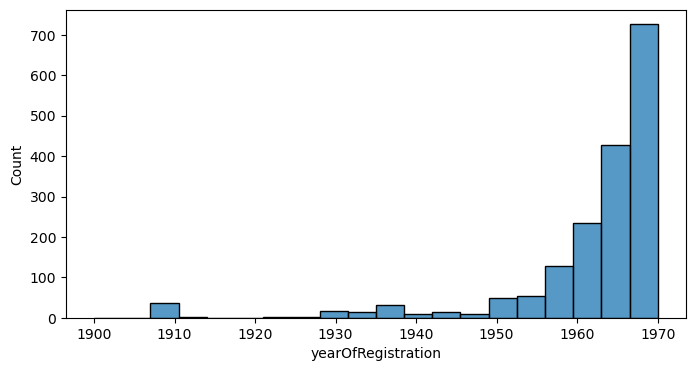

In [46]:
plt.figure(figsize=(8, 4))

sns.histplot(df['yearOfRegistration'], bins=20, binrange=(1900, 1970))
plt.show()

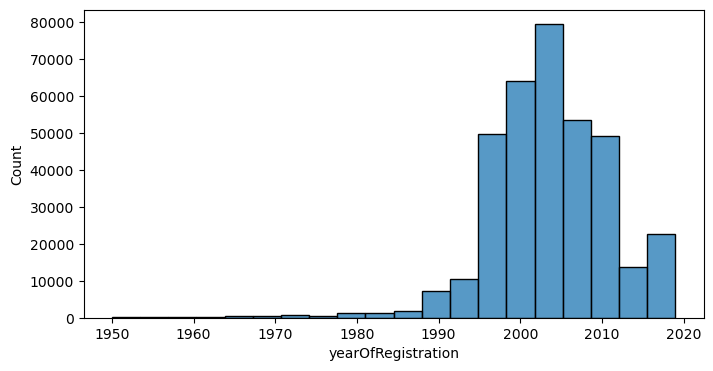

In [47]:
plt.figure(figsize=(8, 4))

sns.histplot(df['yearOfRegistration'], bins=20, binrange=(umbral_fecha, 2019))
plt.show()

podemos examinar individualmente las entradas de vehiculos mas antiguos para ver si genuinamente son errores

In [48]:
df[df['yearOfRegistration'] < umbral_fecha].sample(5)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
357294,A3_zu_verkaufen,700,NaN,1600,manually,1578.0,150000,petrol,audi,no
223909,4_WINTERKOMPLETTRÄDER__225_/55_R_16_____neuwer...,380,NaN,1000,NaN,0.0,5000,NaN,bmw,NaN
274801,Ford_escord_xr3i_Sport,189,NaN,1910,NaN,0.0,150000,NaN,ford,NaN
28823,Chrysler_Windsor_Oldtimer,13300,NaN,1949,NaN,98.0,60000,petrol,chrysler,NaN
201646,Ford_Ford_Model_A_1931_Sedan_Hot_Rod_V8_Flathead,22950,combi,1931,manually,0.0,20000,petrol,ford,no


- Vemos que la mayoría de estas entradas parecen ser erróneas por lo que directamente vamos a aplicar un filtro para eliminarlarlas.
- También podríamos convertir su año a nulo y luego gestionarlos, per al tener tan poca información y ser pocas entradas del dataset no nos compensa.

In [49]:
#Nos quedamos con las entradas que sean posterirores a 1950 (el umbral de años que hemos establecido)
df = df[df['yearOfRegistration'] > umbral_fecha]

## Columna `powerCV` 

- Un vehículo con una potencia de más de 1200 CV practicamente no existe, y menos aún que se venda de segunda mano.
- Estos valores seran convertidos a nulos
- Por otro lado, es poco frecuente tener vehículos en el rango entre 550 CV y 1200CV, incluso siendo deportivos. Vamos a ver la distribución de este rango.

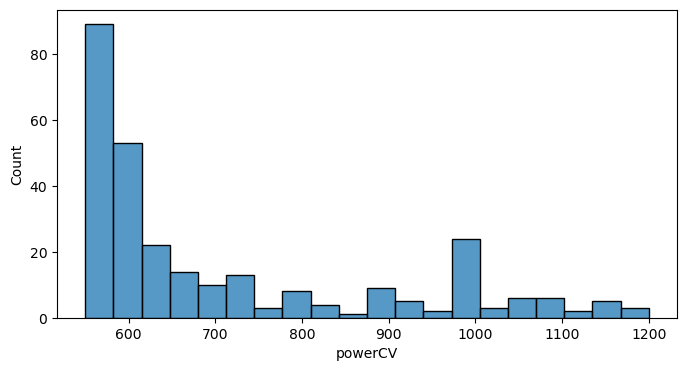

In [50]:
umbral_superior_cv = 550

plt.figure(figsize=(8, 4))

sns.histplot(df['powerCV'], bins=20, binrange=(umbral_superior_cv, 1200))
plt.show()

In [51]:
df[df['powerCV'] > umbral_superior_cv].shape

(518, 10)

In [52]:
df[df['powerCV'] > umbral_superior_cv]

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
1898,Toyota_Corolla,3200,small car,2004,manually,1379.0,5000,petrol,toyota,no
2735,Ferrari_California_F1,120000,convertible,2012,automatic,657.0,20000,petrol,sonstige_autos,no
4254,Mitsubishi_Colt_Diesel_1_5,3100,NaN,2005,manually,940.0,150000,diesel,mitsubishi,no
5582,verkauf__bastler__export,500,combi,1999,manually,987.0,150000,petrol,opel,NaN
6593,Daewoo_Chevrollet_Matiz_2002_zu_verkaufen,599,small car,2002,manually,595.0,5000,petrol,chevrolet,yes
...,...,...,...,...,...,...,...,...,...,...
369007,!!!!!_Opel_zafira_2.0_dti_16_v_comfort_verkauf...,1500,bus,2001,manually,987.0,5000,diesel,opel,no
370612,Dodge_journey_sxt_crd,12500,NaN,2017,manually,1973.0,60000,diesel,chrysler,no
370760,Citroën_c2,2400,NaN,2007,manually,641.0,150000,petrol,citroen,NaN
371196,Cadillac_CTS_V_Dt.Modell_Garantie_3/17_Magnafl...,42000,NaN,2012,automatic,556.0,50000,petrol,sonstige_autos,no


In [53]:
df = df[df['powerCV'] < umbral_superior_cv]

En cuanto al rango inferior de potencia, los vehiculos con potencia inferior a cierto valor no son realistas.Los vehículos menos potentes del mercado pueden llegar hasta 50CV.Pongamos el umbral de 40CV, para permitir la posibilidad de que vehículos más antiguos o modestos puedan llegar a niveles mas bajos
- Veamos algunas entradas


In [60]:
df[df['powerCV'] < 40].sample(5)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
286924,Volkswagen_Polo_1.2,2500,small car,2005,manually,0.0,150000,petrol,volkswagen,no
226579,Peugeot_307_Kombi_1.6_LPG_GAS,2000,small car,2003,manually,0.0,150000,NaN,peugeot,no
43409,Auto_mit_Schaeden_fuer_Bastler_und_kreative_Ko...,150,NaN,1997,manually,0.0,150000,petrol,seat,yes
290571,Fiat_126_Bastlerfahrzeug,400,small car,1989,manually,26.0,5000,NaN,fiat,NaN
27071,Toyota_Corolla_XLi__4WD_Alrad,1500,combi,1988,manually,0.0,150000,petrol,toyota,no


In [61]:
df[df['powerCV'] < 40].shape[0]

36668

In [70]:
round(df[df['powerCV'] < 40].shape[0] / df.shape[0], 2) * 100

10.0

Vemos que hay muchas entradas con un valor de 0 o valores que no tienen sentido. Caomo son bastantes entradas (10%), no las vamos a eliminar, sino que las reemplazaremos por valores nulos.

In [72]:
# Generar nulos para estos valores
df['powerCV'] = df['powerCV'].apply(lambda x: np.nan if x < 40 else x)